In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torch.autograd import Variable
from torch.backends import cudnn


import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np


# Augmenting library 

import torchvision
import torchvision.transforms.functional as TF
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print(torch.cuda.device_count())


# logging
import datetime
from tensorboardX import SummaryWriter
from tqdm import tqdm
import time 

/home/sklab2/anaconda3/envs/vessel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1


In [2]:
import joint_transforms
from config import cod_training_root
from config import backbone_path
from datasets import ImageFolder
from misc import AvgMeter, check_mkdir
from PFNet import PFNet
from helper import FocalLoss, CosineAnnealingWarmupRestarts
import loss

# Config

In [3]:
ckpt_path = './ckpt'
exp_name = 'PFNet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'epoch_num': 300,
    'train_batch_size': 32,
    'last_epoch': 0,
    'lr': 1e-4, 
    'lr_decay': 0.9,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'snapshot': '',
    'scale': 416, 
    'save_point': [],
    'poly_train': False,
    'optimizer': 'Adam',
    'amp' : False
}

In [4]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.reshape(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.0*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

dice_loss = DiceLoss()

In [5]:
# def dice_loss(pred, target, smooth = 1.):
#     pred = pred.contiguous()
#     target = target.contiguous()
#     intersection = (pred * target).sum(dim=2).sum(dim=2)
#     loss = (1 -   ( (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))  )
#     return loss.mean()


# def soft_dice_loss(inputs, targets):
#         num = targets.size(0)
#         m1  = inputs.view(num,-1)
#         m2  = targets.view(num,-1)
#         intersection = (m1 * m2)
#         score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
#         score = 1 - score.sum()/num
#         return score

# Net

In [6]:
from SA_Unet import SA_UNet

net = SA_UNet(in_channels=3, num_classes=3 , base_c=16)
optimizer = torch.optim.Adam(net.parameters(), lr=args['lr'])
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=50, cycle_mult=1.0, max_lr=1e-3, min_lr=1e-5, warmup_steps=5, gamma=0.8)

## making data index list

In [7]:
mask_files = os.walk("/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/masked")
mask_idx = []
for (root, dirs, files) in mask_files:
    if len(files) > 0 :
        mask_idx.append(files)

mask_idxs = [element for array in mask_idx for element in array]
len(mask_idxs)

1691

In [8]:
# 1~ 11 / 12, 13, 14  , 40, 41, 43, 44, 46, 49,  50, 53, 54, 55 
train_indexs = []
test_indexs = []
for idx, data in enumerate(mask_idxs):
    tmp = mask_idxs[idx].split('_')
    if len(tmp) < 3:
        if int(tmp[0]) < 45:
            train_indexs.append([ tmp[0], tmp[1].split('.')[0]])
        else:
            test_indexs.append([tmp[0], tmp[1].split('.')[0]])

In [9]:
len(train_indexs) , len(test_indexs)

(1319, 355)

# Dataloader

In [10]:
import albumentations.augmentations.functional as AF

PATH = '/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/'
class VesselDataset(Dataset):
    def __init__(self, index, transforms):
        self.index = index
        self.transforms = transforms
        
    def __len__(self):
        return len(self.index)
        
    def __getitem__(self, idx):
        s_1 = self.index[idx][0]
        s_2 = self.index[idx][1]

        # '1_L_0.jpg', 
        # image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg').convert("L").resize((416, 416),Image.Resampling.BILINEAR)
        image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg').resize((416, 416),Image.Resampling.BILINEAR)
        #'10_L_112_L.png', 
        mask = Image.open(PATH+'masked/' +  s_1+'_'+s_2+'.png').resize((416, 416),Image.Resampling.BILINEAR)
        
        image = np.array(image, dtype=np.uint8) #RGB
        mask = np.array(mask, dtype=np.uint8)   # HWC
        # mask_o = mask / 255        # CHW
        mask_o = mask.transpose(2, 0, 1)
        lower_red = np.array([-10, 100, 100]) 
        upper_red = np.array([10, 255, 255])

        lower_yellow = np.array([22, 93, 0]) 
        upper_yellow = np.array([45, 255, 255])

        # lower_yellow = np.array([55, 60, 200]) 
        # upper_yellow = np.array([60, 255, 255]) 

        mask_hsv = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)

        mask_r = cv2.inRange(mask_hsv, lower_red, upper_red)
        mask_y = cv2.inRange(mask_hsv, lower_yellow, upper_yellow)
        # mask_y = 255 - mask_y # 색반전
        mask_r = mask_r/255
        mask_y = mask_y/255

        mask_r = np.clip(mask_r, 0 ,1)
        mask_y = np.clip(mask_y, 0, 1)

        mask_r = np.expand_dims(mask_r,axis=0)
        mask_y = np.expand_dims(mask_y,axis=0)

        # mask = np.concatenate([mask_r, mask_y], axis=0)
        masks = [mask_r, mask_y]
        # print(mask.shape)
    
        # aft_mask = cv2.resize(aft_mask, (416, 416), interpolation=cv2.INTER_NEAREST)
        # for num in range(3): #### 3번 이터레이션이 왜들어갔지?
        if self.transforms:
            transformed = self.transforms(image=image, masks=masks)
            image, masks = transformed['image'], transformed['masks']

        mask = np.concatenate([masks[0], masks[1]], axis=-3)
        mask = torch.from_numpy(mask).type(torch.LongTensor)
        
        # urls.append(s_1+'_'+s_2)
        # assert sum(masks[0]==0).sum() + sum(masks[0]==1).sum() == 416*416   # mask가 0 또는 1이 아닐경우 스탑
                    
        return image, mask, mask_o

In [11]:
import albumentations.pytorch as AP

train_transforms = A.Compose([
    # A.RandomRotate90(p=0.25),
    # A.HorizontalFlip(p=0.25),
    # A.VerticalFlip(p=0.25),
    # A.OneOf([
    #     A.OpticalDistortion(p=1, distort_limit=0.1, interpolation=cv2.INTER_LINEAR),
    #     A.GridDistortion(p=1, interpolation=cv2.INTER_LINEAR),
    #     A.ElasticTransform(p=1, interpolation=cv2.INTER_LINEAR),
    #     ], p = 0.5),  # 밝기 및 조도 변화
    # # A.Normalize(mean=(126.71482973095203, 126.6879562017254, 126.85466873988524), std = (32.9434, 33.0122, 32.9186)),
    # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
    AP.ToTensorV2(transpose_mask=False),
])

test_transforms = A.Compose([
    AP.ToTensorV2(transpose_mask=False)
])

train_dataset = VesselDataset(index=train_indexs, transforms=train_transforms)
test_dataset = VesselDataset(index=test_indexs, transforms=test_transforms)
 
#train_dataset, _, test_dataset = torch.utils.data.random_split(dataset, [train, 0, test])

train_loader = DataLoader(dataset=train_dataset, batch_size=args['train_batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# image, [mask_r, mask_y, mask_o] =next(iter(train_loader))
image, mask, mask_o = next(iter(train_loader))
print(image.shape, mask.shape, mask_o.shape)

torch.Size([32, 3, 416, 416]) torch.Size([32, 2, 416, 416]) torch.Size([32, 3, 416, 416])


In [12]:
from sklearn.metrics import jaccard_score, precision_score, recall_score
def calc_metric(labels, preds):
    accuracy = np.mean(np.equal(labels,preds))
    right = np.sum(labels *preds == 1)
    precision = right / np.sum(preds)
    recall = right / np.sum(labels)
    f1 = 2 * precision*recall/(precision+recall)

    
    y_pred = preds
    y_true = labels
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)

    print('jaccard, f1, recall, precision, acc')
    print(score_jaccard, f1, recall, precision, accuracy)
    return score_jaccard, f1, recall, precision, accuracy

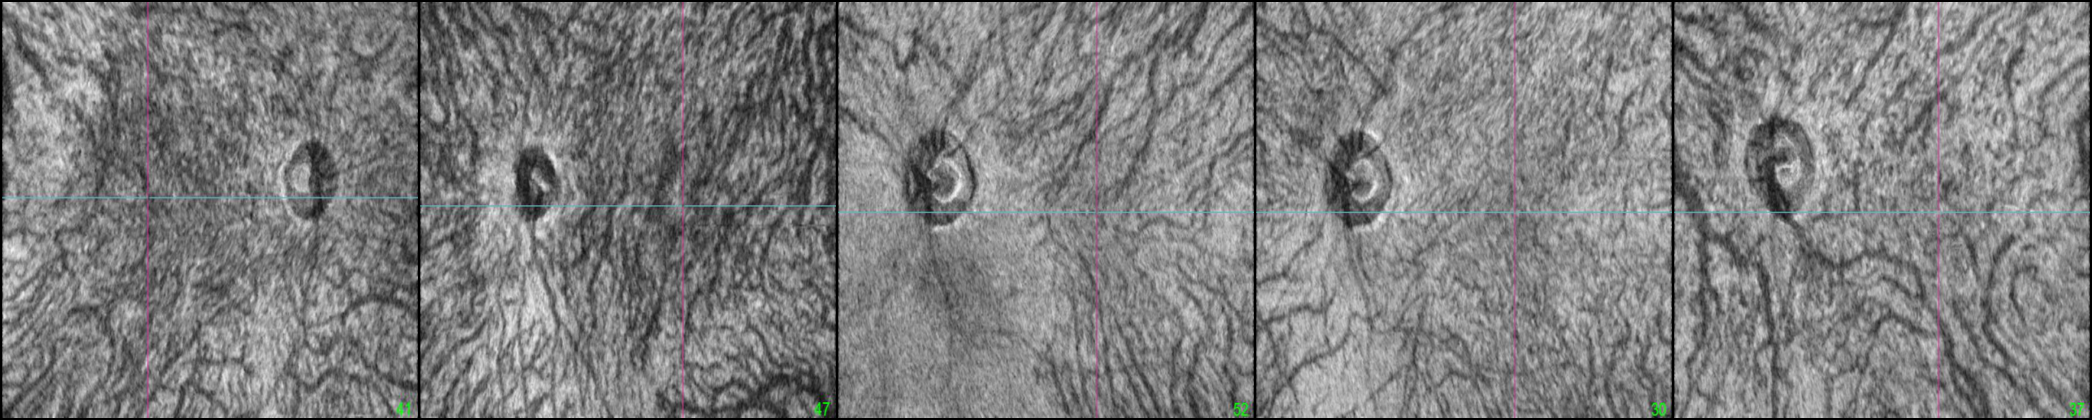

In [13]:
TF.to_pil_image(torchvision.utils.make_grid(image[:5]))

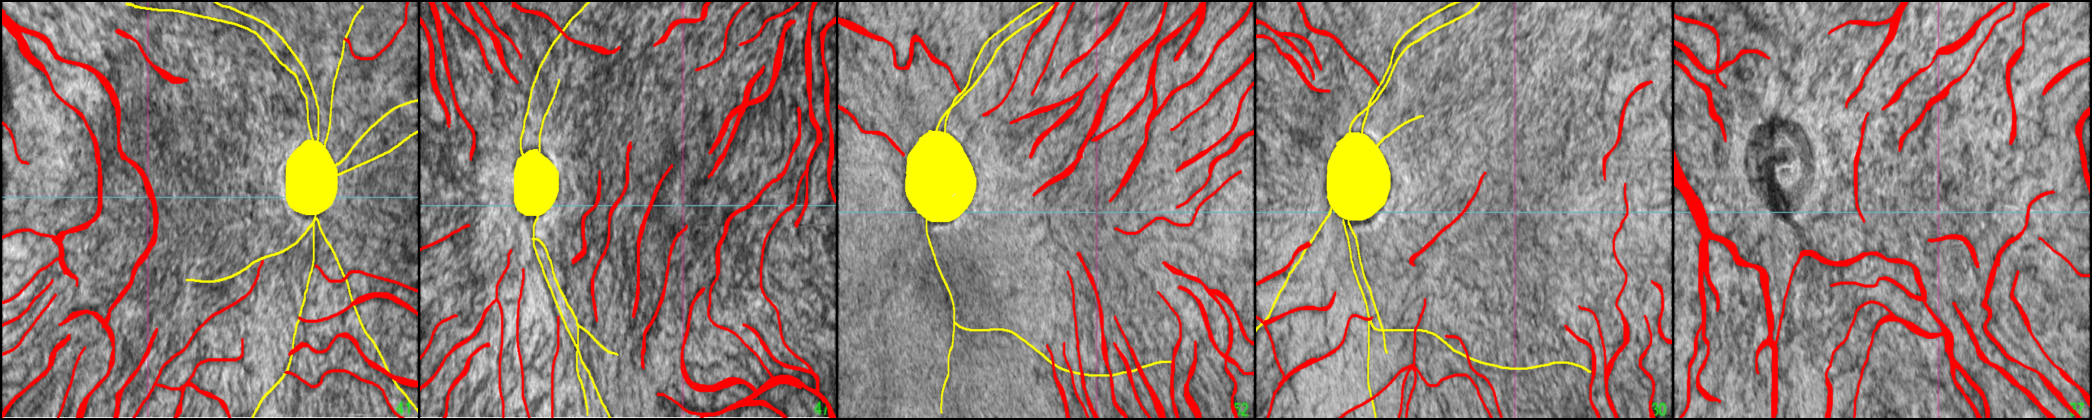

In [14]:
TF.to_pil_image(torchvision.utils.make_grid(mask_o[:5]))

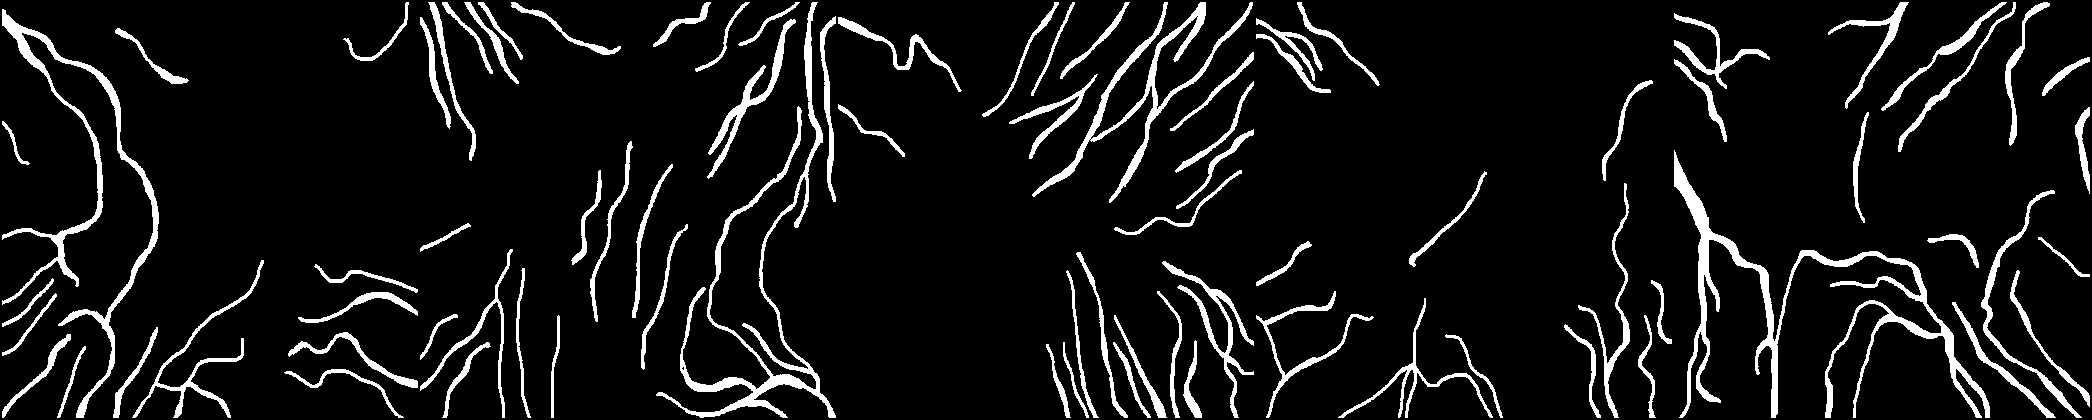

In [15]:
TF.to_pil_image(torchvision.utils.make_grid(mask[:5, 0].unsqueeze(-3).expand(5, 3, 416, 416).type(torch.float)))

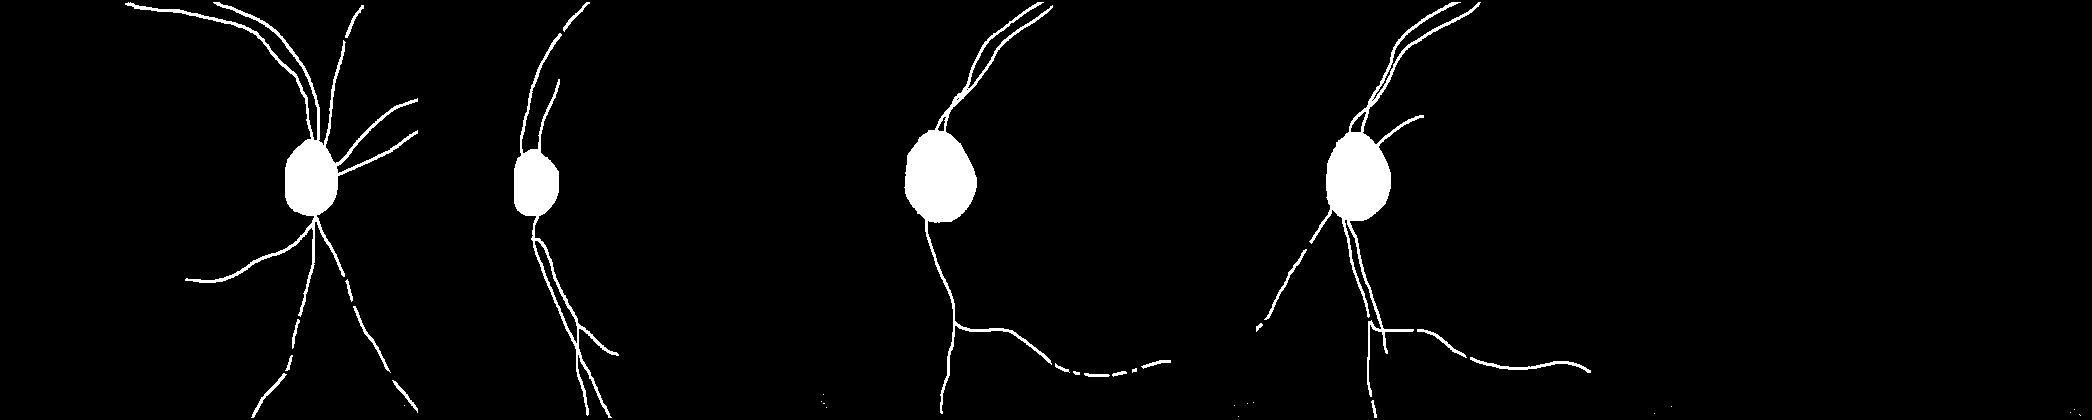

In [16]:
TF.to_pil_image(torchvision.utils.make_grid(mask[:5, 1].unsqueeze(-3).expand(5, 3, 416, 416).type(torch.float)))

In [17]:
# net(image.float()).shape

# Train

In [ ]:
from typing import DefaultDict
from sklearn.exceptions import DataDimensionalityWarning
from tensorboardX import SummaryWriter
import datetime 

exp = 'SA-UNet_2lb+aug+coslr'

num_epochs = args['epoch_num']
resume_epochs = args['last_epoch']
load_from = '../model/vessel_PFNet_base_b32_e500_220921_00:30.pt'


batch_size = args['train_batch_size']
scaler = torch.cuda.amp.GradScaler()
now = datetime.datetime.now()
log_name = f'{exp}_b{batch_size}_e{num_epochs}_js_'+now.strftime("%y%m%d_%H:%M")
writer = SummaryWriter(log_dir='./ckpt/PFNet/log/'+ log_name)
save_path = f'../model/vessel_{exp}_b{batch_size}_e{num_epochs}_'+ now.strftime("%y%m%d_%H:%M") + '.pt'

if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    
net = nn.DataParallel(net)

# net.float()
net = net.to(device)
train_loss_list = []
test_acc_list = []
test_recall_list = []
test_f1_list = []
test_miou_list = []
print(log_name)
print(save_path)
print(f'Training {num_epochs} epochs.')
if resume_epochs != 0:
    print(f'Resuming from epoch {resume_epochs}')
    net.load_state_dict(torch.load(load_from))
if args['amp'] == True:
    print("Using mixed precision.")

# print(data.shape, aug_masks[0].shape, aug_masks[1].shape, aft_mask.shape)
curr_iter = 1

for epoch in range(args['last_epoch'], args['last_epoch'] + args['epoch_num']):
    
    net.train()

    loss_running = 0
    tqdm_dataset = tqdm(train_loader)
    for batch_idx, batch in enumerate(tqdm_dataset):
        if args['poly_train']:
            base_lr = args['lr'] * (1 - float(curr_iter) / float(num_epochs)) ** args['lr_decay']
            optimizer.param_groups[0]['lr'] = 2 * base_lr
            optimizer.param_groups[1]['lr'] = 1 * base_lr
        # label: ([32, 2, 416, 416])
        image, mask, _= batch
        image = image.float().to(device)
        mask = mask.long().to(device)
        optimizer.zero_grad()

        pred = net(image)
        loss = dice_loss(pred, mask)
        
        loss_r = dice_loss(pred[:, 0], mask[:, 0])
        loss_y = dice_loss(pred[:, 1], mask[:, 1])

        loss = loss_r + loss_y
        # loss = loss_r + 0.5 * loss_y
        # loss = loss_r + 0.2*loss_y
        # loss = loss_r
        
        loss.backward()
        # nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        optimizer.step()
        
        loss_running += loss.item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch,
            'Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(loss_running/(batch_idx+1)),
            'lr' : '{:06f}'.format(optimizer.param_groups[0]["lr"])
        })

        curr_iter += 1

    epoch_loss = loss_running / len(train_loader)

    writer.add_scalar('loss/Train', epoch_loss, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    train_loss_list.append(epoch_loss)
    scheduler.step()

## EVAL
    if epoch % 10 == 0 or epoch == args['epoch_num']-1 :
        print("Testing...")

        images=[]
        preds=[]
        mask_rs = []
        mask_ys = []
        mask_os = []
        
        net.eval()
        # tqdm_loader = tqdm(test_loader)
        with torch.no_grad():
            loss_running = 0
            for idx, batch in enumerate(tqdm(test_loader)):

                image, mask, mask_o= batch
                image = image.float().to(device)
                mask = mask.long().to(device)
                pred = net(image)

                loss_r = dice_loss(pred[:, 0], mask[:, 0])
                loss_y = dice_loss(pred[:, 1], mask[:, 1])

                loss = loss_r + loss_y
                # loss = loss_r + 0.5 * loss_y
                loss_running += loss.item()

                images.append(image.cpu().detach().numpy())
                mask_rs.append(mask[:, 0].cpu().detach().numpy())
                mask_ys.append(mask[:, 1].cpu().detach().numpy())
                preds.append(pred[0].cpu().detach().numpy())
                mask_os.append(mask_o)

            images= np.array(images)#.squeeze(1)
            preds = np.expand_dims(np.array(preds)[:, 0], axis=1)
            mask_rs = np.array(mask_rs)
            mask_ys = np.array(mask_ys)
            
            preds = np.where(preds > 0.5 , 1 , 0)
            mask_rs = np.where(mask_rs > 0.5 , 1 , 0)
            mask_ys = np.where(mask_ys > 0.5 , 1 , 0)
            mask_os = np.array(mask_os)
            print(mask_rs.shape, preds.shape)
            epoch_loss = loss_running / len(test_loader)
            print(f"Test loss: {epoch_loss}")
            score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=mask_rs, preds=preds)
            
            test_acc_list.append(score_acc)
            test_recall_list.append(score_recall)
            test_f1_list.append(score_f1)
            test_miou_list.append(score_jaccard)

            writer.add_scalar('loss/Test', epoch_loss, epoch)
            writer.add_scalar('Accuracy/Test', score_acc, epoch)
            writer.add_scalar('F1/Test', score_f1, epoch)
            writer.add_scalar('Recall/Test', score_recall, epoch)
            writer.add_scalar('Precision/Test', score_precision, epoch)
            writer.add_scalar('Jaccard/Test', score_jaccard, epoch)

            if np.max(test_miou_list) == test_miou_list[-1]:
                torch.save(net.state_dict(), save_path)
                print("Model Saved")

            randnum = np.random.randint(0, 171)
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)  
            plt.imshow(mask_os[randnum][0].permute(1, 2, 0))
            plt.subplot(1, 3, 2)  
            plt.imshow(mask_rs[randnum][0])
            plt.subplot(1, 3, 3)
            plt.imshow(preds[randnum][0])
            plt.tight_layout()
            plt.show()

# evaluation

In [ ]:
print("Testing...")
net = SA_UNet(in_channels=3, num_classes=2 , base_c=16)
load_from = '/home/sklab2/workspace/code_only/junsu/model/vessel_SA-UNet_2lb_base_b32_e300_221002_12:16.pt'
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
net = nn.DataParallel(net)
net.load_state_dict(torch.load(save_path))
net.to(device)

images=[]
preds=[]
mask_rs = []
mask_ys = []
mask_os = []

net.eval()
# tqdm_loader = tqdm(test_loader)
with torch.no_grad():
    loss_running = 0
    for idx, batch in enumerate(tqdm(test_loader)):

        image, mask, mask_o= batch
        image = image.float().to(device)
        mask = mask.long().to(device)
        pred = net(image)

        loss_r = dice_loss(pred[:, 0], mask[:, 0])
        loss_y = dice_loss(pred[:, 1], mask[:, 1])

        loss = loss_r + loss_y
        # loss = loss_r + 0.5 * loss_y
        loss_running += loss.item()

        images.append(image.cpu().detach().numpy())
        mask_rs.append(mask[:, 0].cpu().detach().numpy())
        mask_ys.append(mask[:, 1].cpu().detach().numpy())
        preds.append(pred[0].cpu().detach().numpy())
        mask_os.append(mask_o)

    images= np.array(images).squeeze(1)
    preds=np.array(preds)
    # preds = np.expand_dims(np.array(preds)[:, 0], axis=1)
    mask_rs = np.array(mask_rs)
    mask_ys = np.array(mask_ys)
    
    preds = np.where(preds > 0.5 , 1 , 0)
    mask_rs = np.where(mask_rs > 0.5 , 1 , 0)
    mask_ys = np.where(mask_ys > 0.5 , 1 , 0)
    mask_os = np.array(mask_os)
    print(mask_rs.shape, preds.shape)
    epoch_loss = loss_running / len(test_loader)
    print(f"Test loss: {epoch_loss}")
    # score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=mask_rs, preds=preds)

In [ ]:
preds.shape

In [ ]:
# mask_os[0][0].permute(1, 2, 0)

In [ ]:
# randnum = np.random.randint(0, len(test_dataset)-10)
randnum=211

fig, axes = plt.subplots(10, 4, figsize = (10,40))
[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, target_ax_1, target_ax_2, mask_ax) in zip(range(randnum, randnum+10), axes):
    
# inputs[:10] , preds[:10], targets[:10], urls_list[:10]) :
    
    image = images[idx].astype(int).transpose(1, 2, 0) # astype(int)
    img_target_1 = np.expand_dims(preds[idx][0], axis=0).transpose(1, 2, 0) 
    img_target_2 = np.expand_dims(preds[idx][1], axis=0).transpose(1, 2, 0) 
    img_mask = mask_os[idx][0].permute(1, 2, 0)
 
    img_ax.imshow(np.clip(image, 0, 255))

    target_ax_1.imshow(img_target_1)
    target_ax_2.imshow(img_target_2)
    mask_ax.imshow(img_mask)

    img_ax.set_title(f'  testing: {idx}')
    target_ax_1.set_title(f' Predicted red: {idx}')
    target_ax_2.set_title(f' Predicted yellow: {idx}')
    
    mask_ax.set_title(f' target   vessel: {idx}')
plt.tight_layout()
plt.show()
 